In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KernelDensity
from sklearn.utils.multiclass import dok_matrix

In [2]:
m1= np.array([-4, 0])
m2 =np.array([-0.5, 0])
cov1= np.array([[4, 0], [0, 1]])
cov2 =np.array([[0.16, 0], [0, 9]])

Question 1

In [3]:
def multivariate(X, mean, covariance):
    d = mean.shape[0]
    M=np.sum(np.dot(X - mean,np.linalg.inv(covariance)) * X - mean, axis=1)
    return 1.0 / np.sqrt(((2 * np.pi) ** d) * np.linalg.det(covariance))* np.exp(-0.5 * M)

In [4]:
def uniformpr(X, loc, scale):
    i = np.logical_and(X >= loc, X <= loc + scale)
    pdf = np.zeros_like(X)
    pdf[i] = 1.0 / scale
    return pdf

In [5]:
def bayesian(m1, m2, covariance1, covariance2, x1r=(-8, 4, 0.05), x2r=(-6, 6, 0.05)):
    x1 = np.arange(*x1r)
    x2 = np.arange(*x2r)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.stack((X1.ravel(),X2.ravel()),axis=1)
    P=np.column_stack((np.random.uniform(0,2,len(X)), np.random.uniform(-1,1,len(X))))
    m3=np.mean(P,axis=0,keepdims=True)

    pbc1 = 0.7 * multivariate(X, mean=m1, covariance=covariance1) + 0.3 * uniformpr(X[:,0],0,2) * uniformpr(X[:,1],-1,1)
    pbc2 = multivariate(X, mean=m2, covariance=covariance2)

    pbc1x = pbc1 * 0.5 / (pbc1 * 0.5 + pbc2 * 0.5)
    pbc2x = pbc2 * 0.5 / (pbc1 * 0.5 + pbc2 * 0.5)
    g = pbc1x >= pbc2x
    plt.contourf(X1, X2, g.reshape(X1.shape),alpha =0.3, cmap='jet')
    plt.scatter(*m1, c='green', marker='x', label='Mean C1 a')
    plt.scatter(m3[:,0], m3[:,1], c='red', marker='+', label='Mean C1 b')
    plt.scatter(*m2, c='blue', marker='o', label='Mean C2')
    plt.xlim(*x1r[:2])
    plt.ylim(*x2r[:2])
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.show()



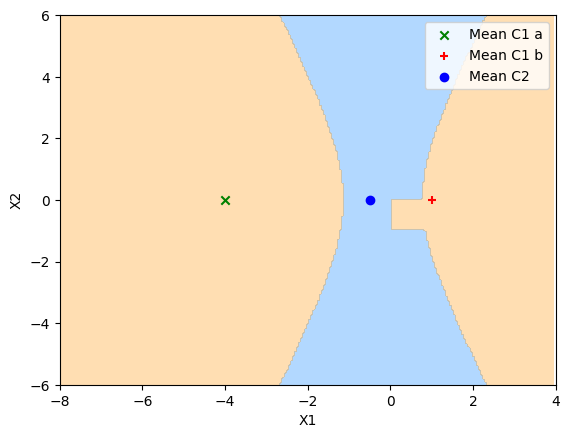

In [6]:
bayesian(m1, m2, cov1, cov2)

Question 2b

In [7]:
n = 20000
ftd = np.zeros((n, 3))
for i in range(n):
    if np.random.random() < 0.5:
        C = 1
        mean = m1
        cov = cov1
    else:
        C = 2
        mean = m2
        cov = cov2
    X = np.random.multivariate_normal(mean, cov)
    X2 = X[0]**2 + X[1]**2
    ftd[i,:] = [X[0], X[1], C]

ftd.shape

(20000, 3)

In [8]:
nt = 10000
ttd = np.zeros((nt, 3))

for i in range(nt):
    if np.random.random() < 0.5:
        C = 1
        mean = m1
        cov = cov1
    else:
        C = 2
        mean = m2
        cov = cov2
    X = np.random.multivariate_normal(mean, cov)
    X2 = X[0]**2 + X[1]**2
    ttd[i, :] = [X[0], X[1],C]
ttd.shape


(10000, 3)

In [9]:
newn = 2000
pd = ftd[:newn, :]

c1d = pd[pd[:, 2] == 1]
c2d = pd[pd[:, 2] == 2]


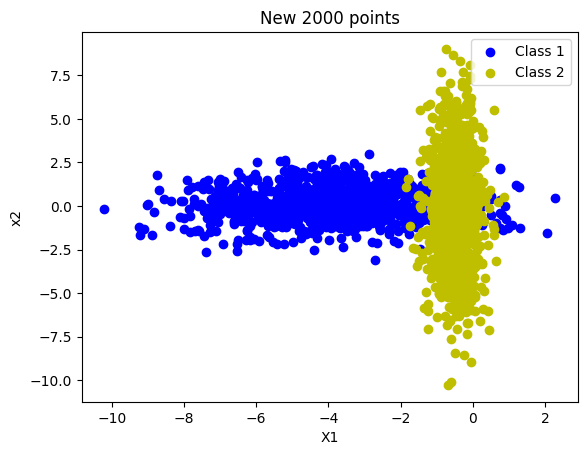

In [10]:
plt.scatter(c1d[:, 0], c1d[:, 1], c='b', label='Class 1')
plt.scatter(c2d[:, 0], c2d[:, 1], c='y', label='Class 2')
plt.xlabel('X1')
plt.ylabel('x2')
plt.title('New 2000 points')
plt.legend()
plt.show()

question 2c

In [11]:
X_train = ftd[:,:2]
y_train = ftd[:,2]

X_test = ttd[:,:2]
y_test = ttd[:,2]

In [12]:
def classify(X):
  pbc1 = 0.7 * multivariate(X, mean=m1, covariance=cov1) + 0.3 * uniformpr(X[:,0],0,2) * uniformpr(X[:,1],-1,1)
  pbc2 = multivariate(X, mean=m2, covariance=cov2)
  Y_pred=np.where(pbc1*0.5>=pbc2*0.5,1,2)
  return Y_pred

In [13]:
Y_pred=classify(X_test)
acc=0
for i in range(len(Y_pred)):
  if Y_pred[i]==y_test[i]:
    acc+=1

print("Test data Accuracy ",acc*100/len(Y_pred))

Test data Accuracy  94.7


Question 2D

In [14]:
def fkde(X_train, y_train, h):
    mkde = []
    
    for label in np.unique(y_train):
        kde = KernelDensity(kernel='gaussian', bandwidth=h)
        kde.fit(X_train[y_train == label])
        mkde.append(kde)
    
    return mkde

def predict(X_test,mkde):
    log_probs = np.stack([kde.score_samples(X_test) for kde in mkde]).T
    y_pred = np.argmax(log_probs, axis=1) + 1
    return y_pred

Priors for n=200: [0.46, 0.54]
Classification accuracy for n=200: 0.937


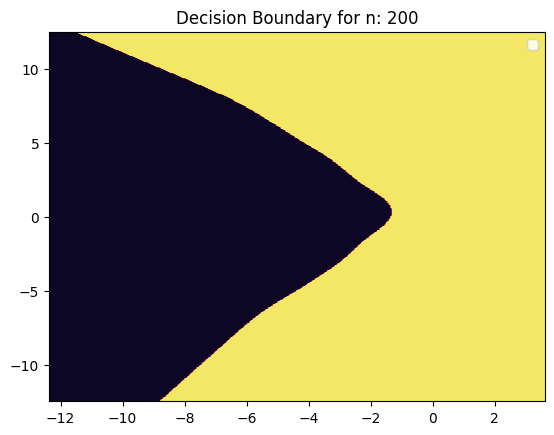

Priors for n=2000: [0.4855, 0.5145]
Classification accuracy for n=2000: 0.946


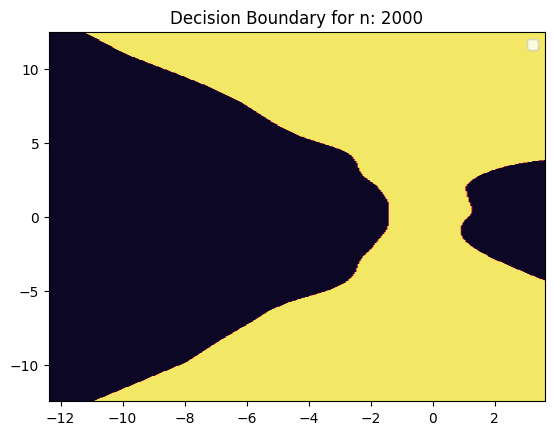

Priors for n=20000: [0.4919, 0.5081]
Classification accuracy for n=20000: 0.9531


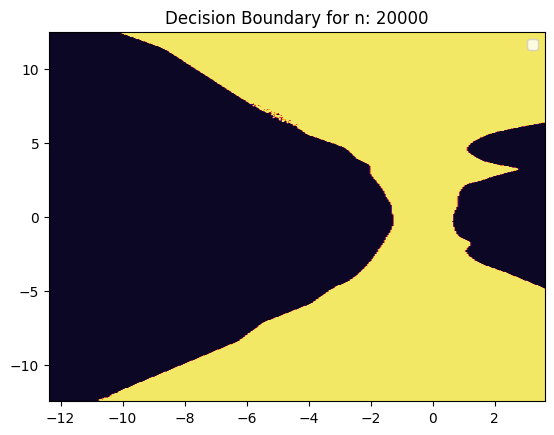

In [15]:
for n in [200, 2000, 20000]:
    X_train_n = X_train[:n,:]
    y_train_n = y_train[:n]
    h = (100/n)**0.25
    priors = [np.sum(y_train_n == label) / n for label in [1, 2]]
    print(f"Priors for n={n}: {priors}")

    mkde = fkde(X_train_n, y_train_n, h)
    y_pred_test= predict(X_test,mkde)
    accuracy = np.mean(y_pred_test == y_test)
    print(f"Classification accuracy for n={n}: {accuracy}")

    lenght=0.05
    x_min,x_max=X_test[:,0].min()-1, X_test[:,0].max()+1
    y_min,y_max=X_test[:,1].min()-1, X_test[:,1].max()+1
    x,y= np.meshgrid(np.arange(x_min,x_max,lenght),np.arange(y_min,y_max,lenght))

    k=predict(np.c_[x.ravel(),y.ravel()],mkde)
    k=k.reshape(x.shape)

    plt.figure()
    plt.contourf(x,y,k,cmap='inferno')
    # plt.scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1],marker='o', color='blue', label='Class-1')
    # plt.scatter(X_test[y_test==2][:,0], X_test[y_test==2][:,1],marker='o', color='orange', label='Class-2')
    plt.title(f'Decision Boundary for n: {n}')
    plt.legend()
    plt.show()